<a href="https://colab.research.google.com/github/christopher540/Prudential_Insurance_Classification/blob/main/Prudential_Insurance_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Risk Level Prediction Model for Life Insurance Applications**

In this project, we will aim to streamline the risk assessment process which might be later used to calculate premium costs that should be incurred to clients


**Dataset Description**

In this [dataset](https://www.kaggle.com/competitions/prudential-life-insurance-assessment/data), we are provided with variables related to the applicants. The task is to predict the Response variable for each applicants in the test data set. Response is an ordinal measure of risk that has 8 levels.



**Model Selection**
To predict the life insurance risk classification, we've employed several  machine learning models, including QDA, AdaBoost Classifier, and Random Forest



**Evaluation Metrics**
To evaluate the effectiveness of our models, we've selected performance metrics that align with our project goals, mainly we'll focus on the accuracy score



### Data Preprocessing

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/Prudential Data/train.csv')
df_test=pd.read_csv('/content/drive/MyDrive/Prudential Data/test.csv')

#### Handle Null Values

In [ ]:
def find_null(df):
  null_cols=df.columns[df.isnull().any()]
  null_sum=df[null_cols].isnull().sum()
  print(f"Columns will null values:\n{null_sum}")

find_null(df_train)
print()
find_null(df_test)

Columns will null values:
Employment_Info_1         19
Employment_Info_4       6779
Employment_Info_6      10854
Insurance_History_5    25396
Family_Hist_2          28656
Family_Hist_3          34241
Family_Hist_4          19184
Family_Hist_5          41811
Medical_History_1       8889
Medical_History_10     58824
Medical_History_15     44596
Medical_History_24     55580
Medical_History_32     58274
dtype: int64

Columns will null values:
Employment_Info_1          3
Employment_Info_4       2137
Employment_Info_6       3787
Insurance_History_5     8105
Family_Hist_2           9880
Family_Hist_3          11064
Family_Hist_4           6677
Family_Hist_5          13624
Medical_History_1       2972
Medical_History_10     19564
Medical_History_15     14864
Medical_History_24     18585
Medical_History_32     19414
dtype: int64


The columns that have missing values is the same for both train and test data, here we will drop columns with more than 75% null values

In [ ]:
threshold=int(np.round(df_train.shape[0]*0.75))
null_cols=df_train.columns[df_train.isnull().sum()>=threshold]
print(f"Minimum number of null values to drop: {threshold}")
print(f"Columns to Drop:\n{null_cols}")

#Drop columns
df_train.drop(columns=null_cols,inplace=True)
df_test.drop(columns=null_cols,inplace=True)

Minimum number of null values to drop: 44536
Columns to Drop:
Index(['Medical_History_10', 'Medical_History_15', 'Medical_History_24',
       'Medical_History_32'],
      dtype='object')


Fill all Null Values with column mean for numerical columns

In [ ]:
# Fill train and test data null values with mean:
numerical_columns_train = df_train.select_dtypes(include=['number']).columns
df_train[numerical_columns_train]=df_train[numerical_columns_train].fillna(df_train[numerical_columns_train].mean())

numerical_columns_test=df_test.select_dtypes(include=['number']).columns
df_test[numerical_columns_test]=df_test[numerical_columns_test].fillna(df_test[numerical_columns_test].mean())


### Exploratory Data Analysis

Continuous Data

Text(0.5, 0, 'Value')

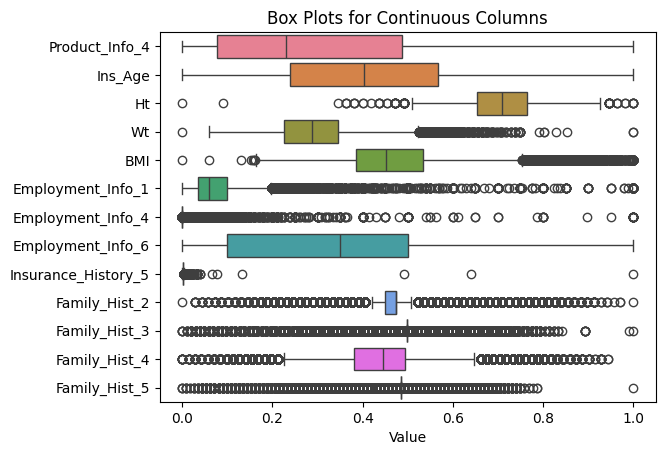

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
continuous = ['Product_Info_4', 'Ins_Age', 'Ht', 'Wt', 'BMI', 'Employment_Info_1',
              'Employment_Info_4', 'Employment_Info_6', 'Insurance_History_5',
              'Family_Hist_2','Family_Hist_3', 'Family_Hist_4','Family_Hist_5']
sns.boxplot(data=df_train[continuous],orient='h')
plt.title("Box Plots for Continuous Columns")
plt.xlabel("Value")


Categorical Data

In [ ]:
df_train.select_dtypes(include=['object','category'])

,Product_Info_2
0,D3
1,A1
2,E1
3,D4
4,D2
...,...
59376,D1
59377,D3
59378,E1
59379,D2


<Axes: xlabel='Product_Info_2', ylabel='count'>

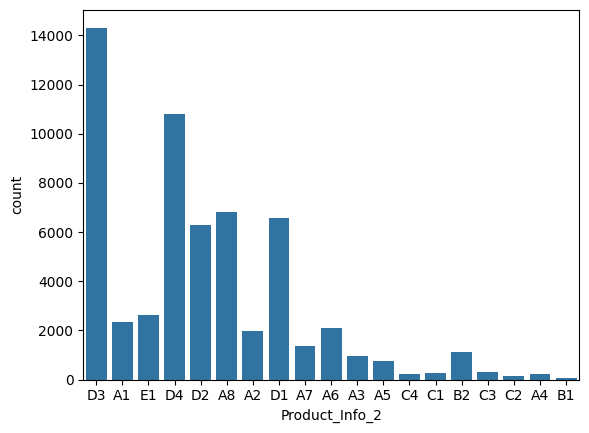

In [ ]:
sns.countplot(data=df_train,x='Product_Info_2')

This column explains which insurance product an applicant is applying for. We observed that D3 is the most common product and overall, there are products that are more popular than the other (ie. D3,D4,D2,A8,D1)

We observe that the continuous data go from 0 to 1 and some outliers are present, however dropping rows is not viable as it is too much, thus we can rely on feature selection to provide a more generalized prediction (less variance)

### Correlation Analysis

In [ ]:
df_train.columns

Index(['Id', 'Product_Info_1', 'Product_Info_2', 'Product_Info_3',
       'Product_Info_4', 'Product_Info_5', 'Product_Info_6', 'Product_Info_7',
       'Ins_Age', 'Ht',
       ...
       'Medical_Keyword_40', 'Medical_Keyword_41', 'Medical_Keyword_42',
       'Medical_Keyword_43', 'Medical_Keyword_44', 'Medical_Keyword_45',
       'Medical_Keyword_46', 'Medical_Keyword_47', 'Medical_Keyword_48',
       'Response'],
      dtype='object', length=124)

In [ ]:
# Assuming df is your DataFrame and 'target' is your target variable
target_variable = 'Response'  # Replace with your actual target variable name

# Create a correlation series with the target variable
correlation_with_target = df_train.select_dtypes(include=['number']).corr()[target_variable]

correlation_with_target.sort_values()

,Response
BMI,-0.381601
Wt,-0.351395
Medical_Keyword_15,-0.259169
Medical_Keyword_3,-0.257706
Ins_Age,-0.209610
...,...
Product_Info_4,0.202434
Medical_History_39,0.220176
Medical_History_4,0.239896
Medical_History_23,0.286584


It is observed that BMI and weight show some correlation with the risk level of the applicant, followed by medical keyword 15,3. Age also play a role in determining the risk level.

### Modelling

Modellng: Data Preprocessing

In [ ]:
#Put Id as index
df_train.index=df_train['Id']
df_train=df_train.drop(['Id'],axis=1)

df_test.index=df_test['Id']
df_test=df_test.drop(['Id'],axis=1)

In [ ]:
df_train=pd.get_dummies(df_train)
df_test=pd.get_dummies(df_test)

Model: Data Fitting

The best model will be determined through accuracy score with 5-fold cross validation

In [ ]:
X=df_train.drop(['Response'],axis=1)
y=df_train['Response']



Quadratic Discriminant Analysis

In [ ]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
import warnings

warnings.filterwarnings("ignore")
model=QuadraticDiscriminantAnalysis()
scores = cross_val_score(model, X, y, cv=5)

mean_accuracy = scores.mean()
print(f"Mean accuracy: {mean_accuracy}")




Mean accuracy: 0.1058580281159078


Random Forrest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
scores = cross_val_score(model, X, y, cv=5)

mean_accuracy = scores.mean()
print(f"Mean accuracy: {mean_accuracy}")

Mean accuracy: 0.5352216809816052


AdaBoostClassifier

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier

model = AdaBoostClassifier()
scores = cross_val_score(model, X, y, cv=5)

mean_accuracy = scores.mean()
print(f"Mean accuracy: {mean_accuracy}")



Mean accuracy: 0.4305417097609315


### Discussion

From the accuracy results, it is observed that the random forrest model is the best model out of the 3 to predict the risk level of applicants given the predictive variables

A reason why the random forrest model might do better is because the dataset has a lot of variables and the nature of random forrest is at each split it will take a subset of the whole predictor variable set. This will enable the trees to have less variance in prediction which leads to better prediction scores.

Adaboost is a boosting algorithm that lets the tree to learn the dataset in small steps however we suspect that due to the large amount of data, it may require more iteration to achieve a better accuracy score.

### Kaggle Submission

In [172]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(X,y)
y_pred=model.predict(df_test)
pd.DataFrame({
    'Id':df_test.index,
    'Response':y_pred
}).to_csv('submission.csv',index=False)